# **Knowledge Graph for Alzheimer's Disease**
***Prince Ofuoku***<br>
***MSc. Bioinformatics***<br>
*28-03-2023*


## **Introduction**
A knowledge graph is a structured, semantically rich representation of knowledge, designed to encode entities and the relationships between them. The primary components of a knowledge graph include nodes that represent entities and edges that depict relationships between entities. The foundational unit of knowledge representation is a triple statement (or fact)consisting of a head (subject), a relation (predicate), and a tail (object).<br>

For example, a triple statement could represent a gene interaction, a drug-disease relationship, or a gene-disease association:
- BRCA1, interacts with, BRCA2
- Aspirin, treats, inflammation
- APOE, associated with, Alzheimer's disease


In this notebook, I'll build a knowledge graph encompassing biomedical entities pertinent to Alzheimer's disease by integrating data related to drugs, genes, pathways, and diseases from different databases, including 
- Comparative Toxicogenomics Database (CTD),
- Kyoto Encyclopedia of Genes and Genomes (KEGG), - Therapeutic Target Database (TTD), 
- STRING, and 
- AGORA.





**Acknowledgement:** Ideas and some codes in this notebook were adapted from https://github.com/freshnemo/AD-KG/blob/main/Pre_process/pre_process.ipynb

In [ ]:
import numpy as np
import pandas as pd
import re

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- folder path

In [ ]:
fp = "/content/drive/MyDrive/Project/data/"

## **Protein-Protein Interactions**
Homo Sapiens interactome from STRING database <br>
Downloaded from https://string-db.org/cgi/download?sessionId=%24input-%3E%7BsessionId%7D&species_text=Homo+sapiens

In [ ]:
string = pd.read_csv(fp + "9606.protein.links.v11.5.txt.gz",
                 compression="gzip", sep=" ")

string.head()

,protein1,protein2,combined_score
0,9606.ENSP00000000233,9606.ENSP00000379496,155
1,9606.ENSP00000000233,9606.ENSP00000314067,197
2,9606.ENSP00000000233,9606.ENSP00000263116,222
3,9606.ENSP00000000233,9606.ENSP00000361263,181
4,9606.ENSP00000000233,9606.ENSP00000409666,270


In [ ]:
string.shape

(11938498, 3)

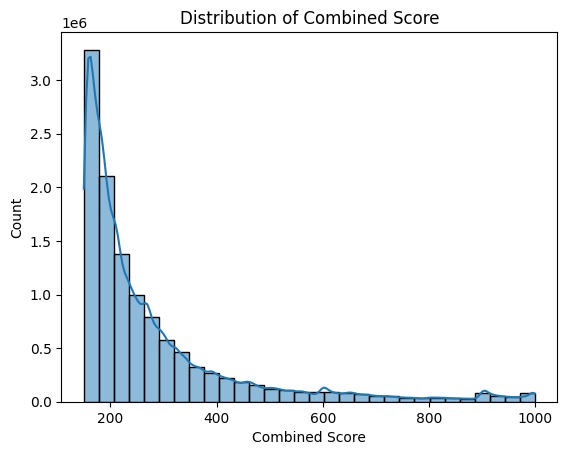

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=string, x='combined_score', bins=30, kde=True)
plt.xlabel('Combined Score')
plt.ylabel('Count')
plt.title('Distribution of Combined Score')
plt.show()


The **"combined_score"** represents the overall confidence score of the interaction between two proteins (protein1 and protein2). The combined score was computed by integrating several types of evidence. Score ranges from 0 to 1000. The higher the combined score, the more reliable the interaction is considered.

In [ ]:
threshold = 650

ppi = string[string.combined_score >= threshold]
ppi = ppi[['protein1','protein2']]
ppi.shape

(630798, 2)

In [ ]:
len(set(ppi["protein1"]).union(set(ppi["protein2"])))

17773

- The proteins above are given as ensembl protein ids
- The code below converts the ids to corresponding gene symbol

In [ ]:
stringInfo = pd.read_csv(fp + "9606.protein.info.v11.5.txt.gz",
                 compression="gzip", delimiter="\t")

stringInfo.head(3)

,#string_protein_id,preferred_name,protein_size,annotation
0,9606.ENSP00000000233,ARF5,180,ADP-ribosylation factor 5; GTP-binding protein...
1,9606.ENSP00000000412,M6PR,277,Cation-dependent mannose-6-phosphate receptor;...
2,9606.ENSP00000001008,FKBP4,459,Peptidyl-prolyl cis-trans isomerase FKBP4; Imm...


Map protein ids to gene symbol (preferred name) using `stringInfo`

In [ ]:
# dict to convert protein_ids to gene symbol
stringInfo = {row[0]:row[1] for _,row in stringInfo.iterrows()}

ppi['protein1'] = ppi.protein1.map(stringInfo)
ppi['protein2'] = ppi.protein2.map(stringInfo)

ppi = ppi.dropna().drop_duplicates().reset_index(drop=True)
ppi.head()

,protein1,protein2
0,ARF5,ACAP2
1,ARF5,RAB1A
2,ARF5,COPE
3,ARF5,ACAP1
4,ARF5,COPZ1


### Represent ppi as triples
ie as head (node), relation(edge), tail(node). In addition, I added two columns indicated the entity type.The labels will be needed (as will be shown later). In this case, they are all genes.


This format (of representing facts in the 5 columns) will be consistent for the rest of this notebook. 

In [ ]:
ppi = ppi.rename(columns={'protein1':'head_entity','protein2':'tail_entity' })
ppi["relation"] = "interacts_with"
ppi["head_label"] = "gene"
ppi["tail_label"] = "gene"

ppi = ppi[["head_entity","relation","tail_entity","head_label","tail_label"]]
ppi.head()

,head_entity,relation,tail_entity,head_label,tail_label
0,ARF5,interacts_with,ACAP2,gene,gene
1,ARF5,interacts_with,RAB1A,gene,gene
2,ARF5,interacts_with,COPE,gene,gene
3,ARF5,interacts_with,ACAP1,gene,gene
4,ARF5,interacts_with,COPZ1,gene,gene


In [ ]:
ppi.shape

(630733, 5)

`geneList` contains list of unique proteins in the ppi network

In [ ]:
geneList = set(ppi["head_entity"]).union(set(ppi["tail_entity"]))
len(geneList)

17771

### **Drug Data**
The file **"drugs_TTD.csv"** contains list of selected drugs for this study (see 1.0_preprocessing.ipynb)

In [ ]:
df = pd.read_csv(fp + "drugs_TTD.csv")
df.head()

,drug_id,drug_name,status,cas_rn,pubchem,smiles
0,D00AEQ,Hydroxyprogesterone,Approved,68-96-2,6238,CC(=O)C1(CCC2C1(CCC3C2CCC4=CC(=O)CCC34C)C)O
1,D00AMQ,Ethanol,Approved,64-17-5,702,CCO
2,D00AOJ,Docosanol,Approved,661-19-8,12620,CCCCCCCCCCCCCCCCCCCCCCO
3,D00AWT,Propericiazine,Approved,2622-26-6,4747,C1CN(CCC1O)CCCN2C3=CC=CC=C3SC4=C2C=C(C=C4)C#N
4,D00AXJ,Miconazole,Approved,22916-47-8,4189,C1=CC(=C(C=C1Cl)Cl)COC(CN2C=CN=C2)C3=C(C=C(C=C...


In [ ]:
drug2cas = {row[1]:row[3] for _, row in df.iterrows()}
drugList = drug2cas.values()
len(drugList)

2800

- `drug2cas`: a utility dict to convert drug name to CAS number
- `drugList`: list of the selected drugs. cas_rn is used for easy integration with other data sources

## **Drug-target**
Drugs and their protein targets. Extracted from TTD (see 1.0_preprocessing.ipynb)

In [ ]:
drug_target = pd.read_csv(fp+"drug_target.csv")
drug_target.head()

,TargetID,DrugID,Highest_status,MOA,uniprot_id,target_names,cas_rn
0,T03818,D0JU5X,Phase 3,Antagonist,PPARG_HUMAN,PPAR-gamma messenger RNA (PPARG mRNA),218600-53-4
1,T51407,D00LNW,Phase 3,Inhibitor,XPO1_HUMAN,Exportin-1 (XPO1),1393477-72-9
2,T40332,D0FT4R,Phase 3,Inhibitor,ELNE_HUMAN,Neutrophil elastase (NE),127373-66-4
3,T22839,D0FT4R,Phase 3,Inhibitor,CELA1_HUMAN,Pancreatic elastase 1 (CELA1),127373-66-4
4,T60529,D0U3EP,Phase 3,Modulator,PGH1_HUMAN,Prostaglandin G/H synthase 1 (COX-1),501-36-0


### Map Uniprot ids to gene symbol

"CTD_genes_9606.csv" contains mapping of entrez ids to gene symbols

In [ ]:
df = pd.read_csv(fp+"CTD_genes_9606.csv")
df.head()

In [ ]:
entrez2symbol ={row[3]:row[0] for _,row in df.iterrows()}

The file "HUMAN_9606_idmapping_selected.tab"contains mapping of uniprot_ids to entrez ids

https://ftp.uniprot.org/pub/databases/uniprot/current_release/knowledgebase/idmapping/by_organism/HUMAN_9606_idmapping_selected.tab.gz) 

In [ ]:
column_names = ["UniProtKB-AC", "UniProtKB-ID", "GeneID", "RefSeq", "GI", "PDB", "GO",
                "UniRef100", "UniRef90", "UniRef50", "UniParc", "PIR", "NCBI-taxon",
                "MIM", "UniGene", "PubMed", "EMBL", "EMBL-CDS", "Ensembl","Ensembl_TRS", 
                "Ensembl_PRO", "Additional PubMed"]

df = pd.read_csv("/content/HUMAN_9606_idmapping_selected.tab", sep="\t", header=None, names=column_names)
df.head(2)

In [ ]:
uniprot2entrez = {row[1]:row[2] for _,row in df.iterrows()}

Create columns for entrez id and gene symbols in `drug_target`

In [ ]:
drug_target["entrez_id"] = drug_target["uniprot_id"].map(uniprot2entrez)
drug_target.dropna(inplace=True)

drug_target["entrez_id"] = pd.to_numeric(drug_target["entrez_id"], errors='coerce')
drug_target["gene_symbol"] = drug_target["entrez_id"].map(entrez2symbol)
drug_target = drug_target.dropna().reset_index(drop=True)

drug_target = drug_target[["cas_rn", "gene_symbol"]]
drug_target.head()

,cas_rn,gene_symbol
0,218600-53-4,PPARG
1,1393477-72-9,XPO1
2,127373-66-4,ELANE
3,127373-66-4,CELA1
4,501-36-0,PTGS1


In [ ]:
drug_target = drug_target.rename(columns={"cas_rn":"head_entity","gene_symbol":"tail_entity"})
drug_target["relation"] = "targets"
drug_target["head_label"] = "drug"
drug_target["tail_label"] = "gene"
drug_target = drug_target[["head_entity","relation","tail_entity","head_label","tail_label"]]
drug_target.head()

,head_entity,relation,tail_entity,head_label,tail_label
0,218600-53-4,targets,PPARG,drug,gene
1,1393477-72-9,targets,XPO1,drug,gene
2,127373-66-4,targets,ELANE,drug,gene
3,127373-66-4,targets,CELA1,drug,gene
4,501-36-0,targets,PTGS1,drug,gene


In [ ]:
drug_target.shape

(1879, 5)

In [ ]:
geneList = list(geneList.union(set(drug_target["tail_entity"])))
len(geneList)

17775

### **Drug-gene interactions** 
Downloaded from CTD (http://ctdbase.org/downloads/)<br>
Fields:
ChemicalName, ChemicalID, CasRN, GeneSymbol, GeneID, GeneForms, Organism, OrganismID,Interaction, InteractionActions, PubMedIDs

In [ ]:
drug_gene = pd.read_csv(fp + "CTD_chem_gene_ixns.csv.gz",
                        compression="gzip", sep =",", comment="#", header=None,
                        names = ["ChemicalName", "ChemicalID", "CasRN", "GeneSymbol", "GeneID", "GeneForms",
                                 "Organism", "OrganismID","Interaction", "InteractionActions", "PubMedIDs"])
#drug_gene.head()

- CasRN will be use for crossRef with TTD drugs. since Name could be ambiguos across databases
- Select data pertaining to humans
- keep only drugs in `drugList`

In [ ]:
drug_gene = drug_gene.loc[drug_gene['Organism']=='Homo sapiens']
drug_gene = drug_gene[drug_gene["CasRN"].isin(drugList)]
drug_gene = drug_gene[drug_gene["GeneSymbol"].isin(geneList)]
drug_gene = drug_gene[["CasRN", "InteractionActions", "GeneSymbol"]].dropna().reset_index(drop=True)
drug_gene.head()

- inspect Interactions

In [ ]:
drug_gene["InteractionActions"].value_counts()

- "increases^expression" and "decreases^expression" are the two most common types of interaction. I'll consider only those two
- This is not a comprehensive study but I try to balance simplicity (network size) and retaining relavant information.

In [ ]:
fx = lambda x: "upregulates" if "increases^expression" in x else "downregulates" if "decreases^expression" in x else np.nan

drug_gene["InteractionActions"] = drug_gene.InteractionActions.apply(fx)
drug_gene = drug_gene.dropna().drop_duplicates().reset_index(drop=True)
drug_gene.head()

,CasRN,InteractionActions,GeneSymbol
0,149-45-1,upregulates,ATF4
1,149-45-1,upregulates,BAD
2,149-45-1,upregulates,BAX
3,149-45-1,downregulates,BCL2
4,149-45-1,upregulates,BECN1


In [ ]:
drug_gene = drug_gene.rename(columns={'CasRN':'head_entity',
                                      'InteractionActions':'relation',
                                      'GeneSymbol':'tail_entity' })

drug_gene["head_label"] = "drug"
drug_gene["tail_label"] = "gene"
drug_gene.head()

,head_entity,relation,tail_entity,head_label,tail_label
0,149-45-1,upregulates,ATF4,drug,gene
1,149-45-1,upregulates,BAD,drug,gene
2,149-45-1,upregulates,BAX,drug,gene
3,149-45-1,downregulates,BCL2,drug,gene
4,149-45-1,upregulates,BECN1,drug,gene


In [ ]:
drug_gene.shape

(112552, 5)

In [ ]:
drug_gene.relation.value_counts()

upregulates      57190
downregulates    55362
Name: relation, dtype: int64

## **Drug - Disease Associations**
- Drug-disease associations were curated by CTD from varoius literature and data sources.
- In addition, I included all Neurodegenarative diseases (NDD) from the database; since we have limited data on AD. I searched NDD and downloaded chemical disease relations file.

In [ ]:
drug_disease = pd.read_csv(fp + "CTD_NDD_chemicals.csv")
drug_disease.head()

In [ ]:
drug_disease["Direct Evidence"].value_counts()

- I'm only interested in "therapeutic" relations ie ***drug treats disease***
- select only drugs in `drugList`



In [ ]:
drug_disease = drug_disease[(drug_disease["Direct Evidence"]=="therapeutic")]
drug_disease = drug_disease[(drug_disease["CAS RN"].isin(drugList))]
drug_disease = drug_disease[["CAS RN", "Disease Name", "Disease ID"]].dropna().drop_duplicates().reset_index(drop=True)
drug_disease.head()

,CAS RN,Disease Name,Disease ID
0,73-31-4,Alzheimer Disease,MESH:D000544
1,458-37-7,Alzheimer Disease,MESH:D000544
2,2086-83-1,Alzheimer Disease,MESH:D000544
3,84371-65-3,Alzheimer Disease,MESH:D000544
4,51-84-3,Alzheimer Disease,MESH:D000544


In [ ]:
drug_disease["Disease Name"].value_counts()

Parkinson Disease                                                                     33
Alzheimer Disease                                                                     31
Amyotrophic Lateral Sclerosis                                                         12
Neurodegenerative Diseases                                                            12
Myasthenia Gravis                                                                      9
Tourette Syndrome                                                                      8
Huntington Disease                                                                     8
Friedreich Ataxia                                                                      5
Tauopathies                                                                            4
Hepatolenticular Degeneration                                                          4
Motor Neuron Disease                                                                   3
Prion Diseases       

In [ ]:
disease2id = {row[1]:row[2] for _, row in drug_disease.iterrows()}
diseaseList = disease2id.values()
len(diseaseList)

29

`disease2id` : for mapping disease name to mesh id<br>
`diseaseList` : list of diseases in the network; 29 in total

In [ ]:
drug_disease = drug_disease.rename(columns={"CAS RN":"head_entity","Disease ID":"tail_entity"})
drug_disease["relation"] = "treats"

drug_disease = drug_disease[["head_entity", "relation", "tail_entity"]]

drug_disease["head_label"] = "drug"
drug_disease["tail_label"] = "disease"
drug_disease.head()

,head_entity,relation,tail_entity,head_label,tail_label
0,73-31-4,treats,MESH:D000544,drug,disease
1,458-37-7,treats,MESH:D000544,drug,disease
2,2086-83-1,treats,MESH:D000544,drug,disease
3,84371-65-3,treats,MESH:D000544,drug,disease
4,51-84-3,treats,MESH:D000544,drug,disease


In [ ]:
drug_disease.shape

(156, 5)

## **Disease-pathway** 
- Pathways involved in NDD
- Curated by CTD. Inferred via genes assocaited with disease
- Pathways here are KEGG and REACT pathways

In [ ]:
disease_pathway = pd.read_csv(fp+"CTD_NDD_pathways.csv")
disease_pathway.head()

- select only disease in `diseaseList`

In [ ]:
disease_pathway = disease_pathway[disease_pathway["Disease ID"].isin(diseaseList)]
disease_pathway = disease_pathway.rename(columns={"Pathway ID":"tail_entity","Disease ID":"head_entity"})

disease_pathway["relation"] = "associated_with_path"
disease_pathway = disease_pathway[["head_entity","relation","tail_entity" ]]

disease_pathway["head_label"] = "disease"
disease_pathway["tail_label"] = "pathway"

disease_pathway.head()

,head_entity,relation,tail_entity,head_label,tail_label
0,MESH:D000544,associated_with_path,REACT:R-HSA-168256,disease,pathway
1,MESH:D000544,associated_with_path,REACT:R-HSA-162582,disease,pathway
2,MESH:D010300,associated_with_path,REACT:R-HSA-1430728,disease,pathway
3,MESH:D000544,associated_with_path,REACT:R-HSA-168249,disease,pathway
4,MESH:D000544,associated_with_path,REACT:R-HSA-1430728,disease,pathway


In [ ]:
disease_pathway.shape

(3896, 5)

In [ ]:
pathwayList = set(disease_pathway["tail_entity"].values)
len(pathwayList)

1335

`pathwayList` unique pathways involved in diseases in the knowledge graph; 1335 in total

## **Disease-gene Association**
Genes associated with NDDs

In [ ]:
disease_gene = pd.read_csv(fp+"CTD_NDD_genes.csv")
disease_gene.head()

In [ ]:
disease_gene = disease_gene[(disease_gene["Disease ID"].isin(diseaseList))]
disease_gene = disease_gene[(disease_gene["Gene Symbol"].isin(geneList))]

disease_gene = disease_gene.rename(columns={"Gene Symbol":"tail_entity","Disease ID":"head_entity"})
disease_gene = disease_gene.reset_index(drop=True)
disease_gene["relation"] = "associated_with_gene"
disease_gene = disease_gene[["head_entity", "relation", "tail_entity"]]
disease_gene["head_label"] = "disease"
disease_gene["tail_label"] = "gene"


disease_gene.head()

,head_entity,relation,tail_entity,head_label,tail_label
0,MESH:D000544,associated_with_gene,APP,disease,gene
1,MESH:D019636,associated_with_gene,SOD2,disease,gene
2,MESH:D010300,associated_with_gene,BDNF,disease,gene
3,MESH:D010300,associated_with_gene,SNCA,disease,gene
4,MESH:D000544,associated_with_gene,IL1B,disease,gene


In [ ]:
disease_gene.shape

(183900, 5)

## **Gene-Pathway Association**
Downloaded from CTD<br>
Fields:
GeneSymbol	GeneID	PathwayName	PathwayID


In [ ]:
gene_pathway = pd.read_csv(fp+"CTD_genes_pathways.tsv",
                 delimiter="\t", comment="#", header=None,
                 names = ["GeneSymbol","GeneID","PathwayName","PathwayID"])
gene_pathway.head()

In [ ]:
gene_pathway = gene_pathway[(gene_pathway["PathwayID"].isin(pathwayList))]
gene_pathway = gene_pathway[(gene_pathway["GeneSymbol"].isin(geneList))]

gene_pathway = gene_pathway.rename(columns={"GeneSymbol":"head_entity","PathwayID":"tail_entity"})
gene_pathway["relation"] = "involves_in_path"
gene_pathway = gene_pathway[["head_entity", "relation", "tail_entity"]]

gene_pathway["head_label"] = "gene"
gene_pathway["tail_label"] = "pathway"

gene_pathway = gene_pathway.dropna().drop_duplicates()
gene_pathway.head()

,head_entity,relation,tail_entity,head_label,tail_label
0,A1BG,involves_in_path,REACT:R-HSA-109582,gene,pathway
1,A1BG,involves_in_path,REACT:R-HSA-168256,gene,pathway
2,A1BG,involves_in_path,REACT:R-HSA-168249,gene,pathway
3,A1BG,involves_in_path,REACT:R-HSA-6798695,gene,pathway
4,A1BG,involves_in_path,REACT:R-HSA-76002,gene,pathway


In [ ]:
gene_pathway.shape

(109289, 5)

## **Drug similarity**
- see 1.0_preprocessing.ipynb

In [ ]:
drug_similarity = pd.read_csv(fp+"drug_similarity.csv")
drug_similarity.head()

,query,target,similarity
0,Miconazole,Tioconazole,0.780000
1,Miconazole,Econazole,0.787234
2,Goserelin,Deslorelin,0.834711
3,Goserelin,Triptorelin,0.827869
4,Goserelin,Leuprorelin acetate,0.829268


- Convert drug name to CAS

In [ ]:
drug_similarity["relation"] = "resembles"
drug_similarity = drug_similarity.rename(columns={"query":"head_entity","target":"tail_entity"})
drug_similarity = drug_similarity[["head_entity","relation","tail_entity"]]

drug_similarity["head_entity"] = drug_similarity["head_entity"].map(drug2cas)
drug_similarity["tail_entity"] = drug_similarity["tail_entity"].map(drug2cas)

drug_similarity["head_label"] = "drug"
drug_similarity["tail_label"] = "drug"
drug_similarity.head()

,head_entity,relation,tail_entity,head_label,tail_label
0,22916-47-8,resembles,65899-73-2,drug,drug
1,22916-47-8,resembles,27220-47-9,drug,drug
2,65807-02-5,resembles,57773-65-6,drug,drug
3,65807-02-5,resembles,57773-63-4,drug,drug
4,65807-02-5,resembles,74381-53-6,drug,drug


In [ ]:
drug_similarity.shape

(435, 5)

### **AD Nominated Genes**
Downloaded from Agora (https://agora.adknowledgeportal.org/genes/nominated-targets)<br>
Researchers have nominated genes that may be good targets for new Alzheimer's Disease treatment or prevention. 

In [ ]:
ad_genes = pd.read_csv(fp + "gene-list.csv")

#ad_genes.head()

In [ ]:
ad_genes = ad_genes[ad_genes["Gene Symbol"].isin(geneList)]

agora = pd.DataFrame({"head_entity": disease2id.get("Alzheimer Disease"),
                           "relation": "associated_with_gene",
                           "tail_entity": ad_genes["Gene Symbol"],
                           "head_label": "disease",
                           "tail_label": "gene"})
agora.head()

,head_entity,relation,tail_entity,head_label,tail_label
0,MESH:D000544,associated_with_gene,MSN,disease,gene
1,MESH:D000544,associated_with_gene,PLEC,disease,gene
2,MESH:D000544,associated_with_gene,PRDX1,disease,gene
3,MESH:D000544,associated_with_gene,PRDX6,disease,gene
4,MESH:D000544,associated_with_gene,RPH3A,disease,gene


In [ ]:
agora.shape

(595, 5)

## **Disease-phenotype**

In [ ]:
ndd_phenotype = pd.read_csv(fp+"CTD_NDD_Phenotype.csv")
ndd_phenotype.head()

In [ ]:
ndd_phenotype.columns

In [ ]:
ndd_phenotype = ndd_phenotype[(ndd_phenotype["Disease ID"].isin(diseaseList))].reset_index(drop=True)

In [ ]:
disease_phenotype = ndd_phenotype.rename(columns={"Disease ID":"head_entity","Phenotype Term ID":"tail_entity"})
disease_phenotype["relation"] = "associated_with_pheno"
disease_phenotype["head_label"] = "disease"
disease_phenotype["tail_label"] = "phenotype"

disease_phenotype = disease_phenotype[["head_entity","relation","tail_entity","head_label","tail_label"]].drop_duplicates()

disease_phenotype.head()

,head_entity,relation,tail_entity,head_label,tail_label
0,MESH:D010300,associated_with_pheno,GO:0006915,disease,phenotype
1,MESH:D000544,associated_with_pheno,GO:0006915,disease,phenotype
2,MESH:D010300,associated_with_pheno,GO:0008219,disease,phenotype
3,MESH:D000544,associated_with_pheno,GO:0008283,disease,phenotype
4,MESH:D010300,associated_with_pheno,GO:0008283,disease,phenotype


In [ ]:
disease_phenotype.shape

(33999, 5)

In [ ]:
phenotypeList = np.unique(disease_phenotype['tail_entity'])
len(phenotypeList)

8634

## **Gene-Phenotype**


In [ ]:
gene_phenotype = ndd_phenotype[["Phenotype Term ID","Gene Inference Network"]].reset_index(drop=True)
gene_phenotype['Gene Inference Network'] = gene_phenotype['Gene Inference Network'].str.split('|')
gene_phenotype.head()

In [ ]:
# Create a new dataframe with separate columns for each gene symbol
split_genes = gene_phenotype['Gene Inference Network'].apply(pd.Series)

# merge both df 
gene_phenotype = pd.concat([gene_phenotype[["Phenotype Term ID"]], split_genes], axis=1)
gene_phenotype= pd.melt(gene_phenotype, id_vars=['Phenotype Term ID'], value_vars=split_genes.columns, value_name='gene_symbol')

gene_phenotype = gene_phenotype.dropna(subset=['gene_symbol'])
gene_phenotype= gene_phenotype.drop_duplicates().reset_index(drop=True).drop(columns=['variable'])
gene_phenotype.head()

,Phenotype Term ID,gene_symbol
0,GO:0006915,CEACAM6
1,GO:0006915,APP
2,GO:0008283,ACE
3,GO:0008283,CNTNAP2
4,GO:0016042,GLAZ


In [ ]:
gene_phenotype = gene_phenotype[gene_phenotype["gene_symbol"].isin(geneList)].reset_index(drop=True)

gene_phenotype = gene_phenotype.rename(columns={"gene_symbol":"head_entity","Phenotype Term ID":"tail_entity"})
gene_phenotype["relation"] = "involves_in_pheno"
gene_phenotype["head_label"] = "gene"
gene_phenotype["tail_label"] = "phenotype"
gene_phenotype = gene_phenotype[["head_entity","relation","tail_entity","head_label","tail_label"]]
gene_phenotype.head()

,head_entity,relation,tail_entity,head_label,tail_label
0,CEACAM6,involves_in_pheno,GO:0006915,gene,phenotype
1,APP,involves_in_pheno,GO:0006915,gene,phenotype
2,ACE,involves_in_pheno,GO:0008283,gene,phenotype
3,CNTNAP2,involves_in_pheno,GO:0008283,gene,phenotype
4,PLCG2,involves_in_pheno,GO:0016042,gene,phenotype


In [ ]:
gene_phenotype.shape

(23543, 5)

#### Bidirecting relation
This accounts for symetrical relations, for example, drug_a resembles drug_b then drug_b resembles drug_a
the function `bidirect` simply swab head and tail enitities to account for symetry

In [ ]:
def bidirect(df):
  df1 = df.copy()
  df1.columns=['tail_entity','relation','head_entity','tail_label','head_label']
  return pd.concat([df,df1], axis=0)



- for example

In [ ]:
df1 = pd.DataFrame({"head_entity":[1,2,3,4],"relation":"binds","tail_entity":["a","b","c","d"],"head_label":"drug","tail_label":"gene"}
                   )
df1.head()

,head_entity,relation,tail_entity,head_label,tail_label
0,1,binds,a,drug,gene
1,2,binds,b,drug,gene
2,3,binds,c,drug,gene
3,4,binds,d,drug,gene


In [ ]:
df1 = bidirect(df1)
df1

,head_entity,relation,tail_entity,head_label,tail_label
0,1,binds,a,drug,gene
1,2,binds,b,drug,gene
2,3,binds,c,drug,gene
3,4,binds,d,drug,gene
0,a,binds,1,gene,drug
1,b,binds,2,gene,drug
2,c,binds,3,gene,drug
3,d,binds,4,gene,drug


In [ ]:
ppi = bidirect(ppi)
drug_similarity = bidirect(drug_similarity)

#### Put all together

In [ ]:
frames = [ppi, agora, drug_similarity, gene_pathway, drug_disease, disease_gene, 
          disease_pathway, drug_gene, disease_phenotype, gene_phenotype, drug_target]

df = pd.concat(frames, ignore_index=True, axis=0)
df = df.drop_duplicates().reset_index(drop=True)
df.head()

,head_entity,relation,tail_entity,head_label,tail_label
0,ARF5,interacts_with,ACAP2,gene,gene
1,ARF5,interacts_with,RAB1A,gene,gene
2,ARF5,interacts_with,COPE,gene,gene
3,ARF5,interacts_with,ACAP1,gene,gene
4,ARF5,interacts_with,COPZ1,gene,gene


In [ ]:
df.shape

(1097315, 5)

In [ ]:
df.relation.value_counts()

interacts_with           630733
associated_with_gene     183911
involves_in_path         109289
upregulates               57190
downregulates             55362
associated_with_pheno     33999
involves_in_pheno         20050
associated_with_path       3896
targets                    1873
resembles                   856
treats                      156
Name: relation, dtype: int64

In [ ]:
len(set(list(df["head_entity"].values)+list(df["tail_entity"].values)))

29776

### Entity labels

In [ ]:
import pickle

# Combine head and tail columns with their respective labels
entities = pd.concat([df[['head_entity', 'head_label']].rename(columns={'head_entity': 'entity', 'head_label': 'label'}),
                      df[['tail_entity', 'tail_label']].rename(columns={'tail_entity': 'entity', 'tail_label': 'label'})],
                            axis=0)

entities = entities.drop_duplicates()

# Create a dictionary with entities as keys and their labels as values
entity2label = dict(zip(entities['entity'], entities['label']))

# Serialize the object and save it to a file
with open(fp+"entity2label.pkl", "wb") as file:
    pickle.dump(entity2label, file)


In [ ]:
entities.label.value_counts()

gene         17775
phenotype     8634
drug          2003
pathway       1335
disease         29
Name: label, dtype: int64

### Visualise Network Schema

In [ ]:
schema = df[["head_label", "relation", "tail_label"]]
schema = schema.drop_duplicates().reset_index(drop=True)
schema

,head_label,relation,tail_label
0,gene,interacts_with,gene
1,disease,associated_with_gene,gene
2,drug,resembles,drug
3,gene,involves_in_path,pathway
4,drug,treats,disease
5,disease,associated_with_path,pathway
6,drug,upregulates,gene
7,drug,downregulates,gene
8,disease,associated_with_pheno,phenotype
9,gene,involves_in_pheno,phenotype


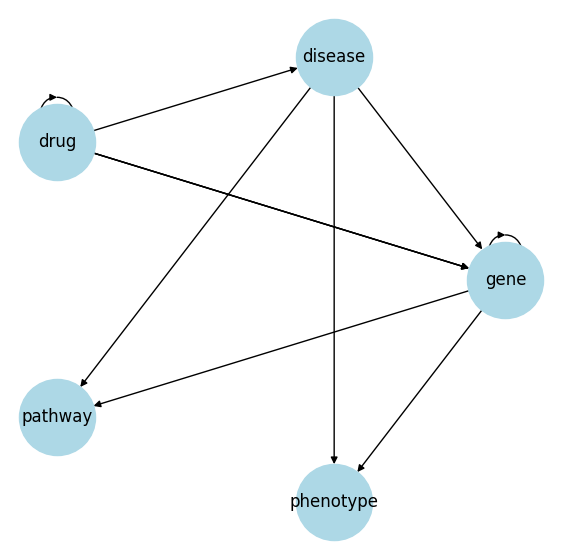

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a directed multigraph
G = nx.MultiDiGraph()

# Add nodes and edges to the graph
for row in schema.to_records(index=False):
    G.add_node(row['head_label'], color='lightblue')
    G.add_node(row['tail_label'], color='lightblue')
    G.add_edge(row['head_label'], row['tail_label'], relation=row['relation'])

# Set positions of nodes
pos = nx.circular_layout(G)

# Draw the graph without edge labels
fig, ax = plt.subplots(figsize=(7, 7))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=3000, font_size=12, ax=ax)

plt.axis('off')
plt.show()

- Finally, Save df without headers and labels as `triples`.
- Next step is to train `triples` on various Embedding models, and the best one will be use for drug repurposing task. See next notebook 

In [ ]:
df.to_csv(fp+"triples_full.csv", index=False)

df = df[["head_entity", "relation", "tail_entity"]]
df.to_csv(fp+"triples_without_labels.tsv", sep='\t', header=False, index=False)

## References

Szklarczyk, D., Gable, A. L., Lyon, D., Junge, A., Wyder, S., Huerta-Cepas, J., ... & Mering, C. V. (2019). STRING v11: protein–protein association networks with increased coverage, supporting functional discovery in genome-wide experimental datasets. Nucleic Acids Research, 47(D1), D607-D613. https://doi.org/10.1093/nar/gky1131